#   [Py4Hw User Guide](../UserGuide.ipynb)> 1.1 Design Style
###  [Next: 1.2 Object Oriented Approach](OO.ipynb)

Hardware design tools typically combine different design styles. 

1. Graphical
    1. Structural
2. Textual (HDL)
    1. Structural
    2. Register Transfer Level (RTL)
    3. Sequential Behavioural (Procedural Programming Languages)

Textual description of Hardware is done by Hardware description languages (HDL). Most popular ones are Verilog, SystemVerilog, VHDL, and MyHDL (also based on Python). 

In **py4hw** we promote the use of structural design style, by reusing as much as possible already designed and proven modules, but we also support RTL and sequential design styles.

In structural design styles a hardware module is build by instantiating other hardware modules and connecting them with wires.

Thus, to create a circuit, the hardware designer has to reuse existing available blocks and create new ones when needed.

By doing that, the design ends up being a set of blocks with a hierarchycal dependence. For instance, let A,B,C,D,E,F be preexisting logic blocks, and A being composed by B and C, and E being composed by A and F. If a hardware designer builds a circuit g reusing A and using a newly created block h using D and E. The hierarchical description of the circuit g would be the following. 

<pre>
g 
+- A
|  +- B
|  +- C
+--h
   +- D
   +- E
      +- A
      |  +- B
      |  +- C
      +- F
</pre>
  
In this case we would say that g is the **top level entity** of the hierarchy

In [2]:
import py4hw

In [3]:
# Imagine the following example
sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
count = py4hw.Wire(sys, 'count', 8)
q = py4hw.Wire(sys, 'q', 8)

py4hw.Constant(sys, 'inc', 1, inc)
py4hw.Add(sys, 'counter', q, inc, count)
py4hw.Reg(sys, 'reg', d=count, enable=inc, q=q)

print('circuit created')

circuit created


The following code shows prints the hierarchy of the system 

In [4]:
py4hw.debug.printHierarchy(sys)

HWSystem
 Constant
 Add
 Reg


## Structural Design Style
Structural design consist on creating instances of other elements.
In **py4hw** this is done in the constructor of the class that implements the circuit.

In [5]:
class Counter(py4hw.Logic):
    def __init__(self, parent, name, inc, q):
        super().__init__(parent, name)
    
        self.addIn('inc', inc)
        self.addOut('q', q)
        
        count = py4hw.Wire(sys, 'count', 8)

        py4hw.Add(self, 'counter', q, inc, count)
        py4hw.Reg(self, 'reg', d=count, enable=inc, q=q)



circuit created


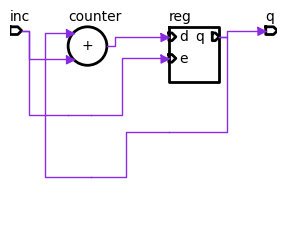

In [6]:

sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
q = py4hw.Wire(sys, 'q', 8)

py4hw.Constant(sys, 'inc', 1, inc)

Counter(sys, 'counter', inc, q)

print('circuit created')

sch = py4hw.Schematic(sys.children['counter'])
sch.draw()

## RTL Design Style
Not all the circuits can be described structurally.

Some circuit primitives (like and, and or gates and registers) are already described behaviourally in the py4hw library.

There are two types of behavioural descriptions: combinational and sequential.

Combinational circuits are modelled by implementing the **propagate** method.

Sequential circuits are modelled by implementing the **clock** method.

Since ports are dynamically created in the class constructor, to have them available in the clock or propagate methods they are typically also stored as members of the circuit class.

<pre>
self.&ltport name&gt = self.addIn('&ltport name&gt', &ltport name&gt)
</pre>

In [13]:
class CounterRTL(py4hw.Logic):
    def __init__(self, parent, name, inc, q):
        super().__init__(parent, name)
    
        self.inc = self.addIn('inc', inc)
        self.q = self.addOut('q', q)
        
        
    def clock(self):
        if (self.inc.get() == 1):
            self.q.prepare(self.q.get()+1)
        


We can create the circuit, and test it to see it is totally equivalent to the structural description

In [14]:
sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
q0 = py4hw.Wire(sys, 'q0', 8)
q1 = py4hw.Wire(sys, 'q1', 8)

py4hw.Sequence(sys, 'inc', [0, 0, 1], inc)

count0 = Counter(sys, 'counter_structural', inc, q0)
count1 = CounterRTL(sys, 'counter_rtl', inc, q1)

print('circuit created')

wvf = py4hw.Waveform(sys, 'wvf', [inc,q0,q1])

sys.getSimulator().clk(20)
wvf.draw_wavedrom()

circuit created


What about the Verilog implementation ?

In [15]:
rtl = py4hw.VerilogGenerator(count0)

print(rtl.getVerilogForHierarchy())

// This file was automatically created by py4hw RTL generator
module Counter (
	input clk50,
	input  inc,
	output [7:0] q);
wire [7:0] w_count;

assign w_count = q + inc;
Reg_1b211726c50 i_reg(.clk50(clk50),.d(w_count),.e(inc),.q(q));
endmodule

// This file was automatically created by py4hw RTL generator
module Reg_1b211726c50 (
	input clk50,
	input [7:0] d,
	input  e,
	output [7:0] q);
reg [7:0] rq = 0;
always @(posedge clk50)
if (e == 1)
begin
   rq <= d;
end
assign q = rq;
endmodule



In [16]:
rtl = py4hw.VerilogGenerator(count1)

print(rtl.getVerilog())

// This file was automatically created by py4hw RTL generator
module CounterRTL_1b211726200 (
	input clk50,
	input  inc,
	output  reg [7:0] q);
// Code generated from clock method
// wire/variable declaration
// initial
initial
begin
end
// process
always @(posedge clk50)
begin
    if (inc==1)
    begin
        q<=q+1;
    end
end
endmodule



## Sequential Design Style
A more common design style for Software programmers are sequential programs defined by procedural programming languages.

In this case, we use sequential cirtuits (implementing the clock method) with python coroutines.

The sequential algorithm is described in the **run** method, and everything that is executed between two invocations of the **yield** statement happen in during the same clock cycle.

We currently do not support Hardware synthesis from this design style, but it is very powerful for simulation.
You can use **yield from** to implement functions, increasing the complexity of the simulation stimuli.

The example below is the same circuit expressed in a Sequential design style.

In [23]:
class CounterSeq(py4hw.Logic):
    def __init__(self, parent, name, inc, q):
        super().__init__(parent, name)
    
        self.inc = self.addIn('inc', inc)
        self.q = self.addOut('q', q)
        
        self.vinc = 0
        self.vq = 0
        
        self.co = self.run()
        
    def clock(self):
        self.vinc = inc.get()
        next(self.co)
        self.q.prepare(self.vq)
        
    def run(self):
        while(True):
            if (self.vinc):
                self.vq += 1
                yield

You can easily verify that the behaviour of all 3 circuits described with different design styles is the same.

In [24]:
sys = py4hw.HWSystem()

inc = py4hw.Wire(sys, 'inc', 1)
q0 = py4hw.Wire(sys, 'q0', 8)
q1 = py4hw.Wire(sys, 'q1', 8)
q2 = py4hw.Wire(sys, 'q2', 8)

py4hw.Sequence(sys, 'inc', [0, 0, 1], inc)

count0 = Counter(sys, 'counter_structural', inc, q0)
count1 = CounterRTL(sys, 'counter_rtl', inc, q1)
count2 = CounterRTL(sys, 'counter_seq', inc, q2)

print('circuit created')

wvf = py4hw.Waveform(sys, 'wvf', [inc,q0,q1,q2])

sys.getSimulator().clk(20)
wvf.draw_wavedrom()

circuit created
